## Required imports ##

In [1]:
from utils import *

iminuit version: 2.31.1


## The expression below gives the cross section of the processes $e^{+}e^{-}\rightarrow  \mu^+\mu^-$, via a $Z^0$ boson, as a function of the centre of mass energy $\sqrt{s}$ and the mass and width of the $Z$ boson ($m_{Z}$, $\Gamma_{Z}$) ##

$$\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-) = \frac{12\pi s}{m_{Z}^{2}}\frac{\Gamma_{ee}\Gamma_{\mu\mu}}{(s-m_{Z}^{2})^{2}+m_{Z}^{2}\Gamma_{Z}^{2}}$$

# Question 1 #

- What are the assumptions that go into the expression above?
- What is the physical meaning of $\Gamma_{ee}$ and $\Gamma_{\mu\mu}$?

## A Python function that returns a numerical value of the aforementioned cross-section $\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-)$ is shown below: ##

In [2]:
def sigma_ee_mm(x,mZ_var,gZ_var,gee_var,gmm_var):
    s = x**2
    mZsq_var = mZ_var**2
    sigma = np.pi*s*gee_var*gmm_var/(mZsq_var*(s-mZsq_var)**2+mZsq_var*gZ_var**2)
    return sigma

## The snippet below plots the cross section as a function of $\sqrt{s}$ ## 

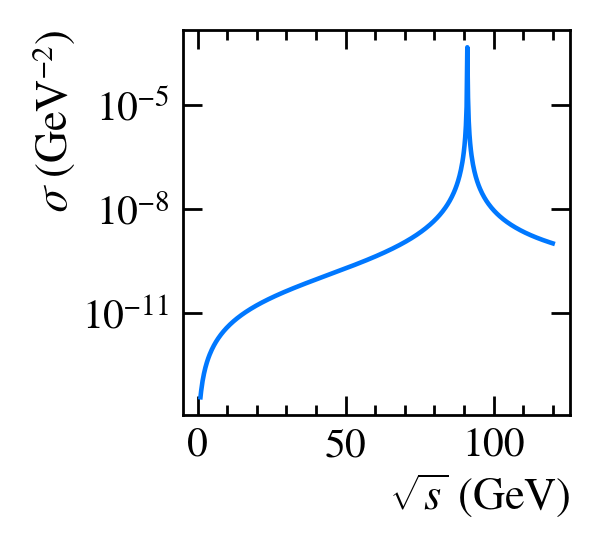

In [3]:
mZ, gZ = 91.18, 2.496   # in GeV 
gee, gmm = 0.084, 0.084 # in GeV
sqrts = np.linspace(1,120,500)
xsec = sigma_ee_mm(sqrts,mZ,gZ,gee,gmm)
plt.figure(figsize=(5,5)) 
plt.tight_layout()
plt.yscale('log')
plt.plot(sqrts,xsec)
plt.xlabel("$\sqrt{s}$ (GeV)")
plt.ylabel("$\sigma$ ($\mathrm{GeV}^{-2})$")
plt.show()

# Question 2 #
- Explain how we arrived at the values of the parameters "gee_val" and "gmm_val" given in the cell above
- The plot above shows the cross-section drop at around 1GeV. Is this effect physical? Explain your reasoning. 

# Question 3 #
- Which parameter would you modify in the expression of the cross section given above in order to describe the process $e^+e^- \to\mathrm{hadrons}$?
- Describe a step-by-step approach to determining the number of generations of neutrinos
    - You are given the measured values of $\sigma_{ee\to\mathrm{hadrons}}$ at a few $\sqrt{s}$ points (TODO)
    - You should use the expression of $\sigma_{ee\to\mathrm{hadrons}}$ 

## The cell below show an example of how to generate some data according to the cross-section function shown above and plot a histogram of the generated values 

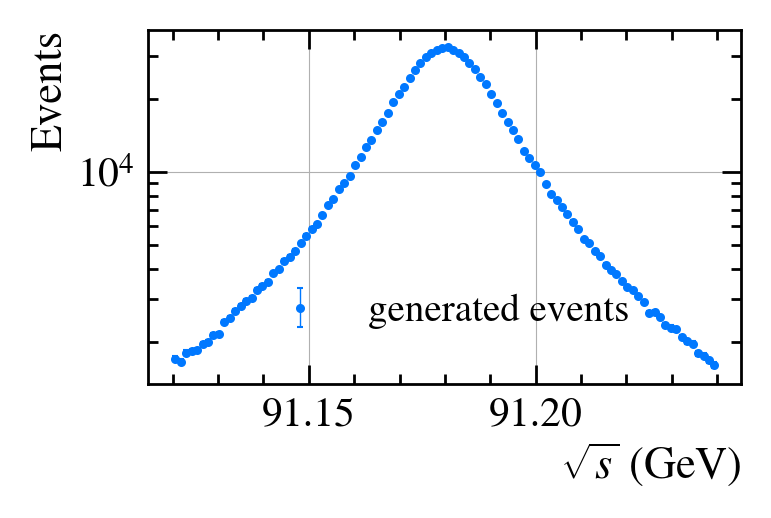

In [4]:
# Generate 1000000 values of sqrts according to the expression of the cross-section function defined
# earlier for CoM energies between sqrts_min and sqrts_max.
sqrts_min = 91.12
sqrts_max = 91.24
n_events = 1000000
sqrts_vals = gen_data(n_events,sigma_ee_mm,x_min=sqrts_min,x_max=sqrts_max,
                      mZ_var=mZ,gZ_var=gZ,gee_var=gee,gmm_var=gmm)

# Plot a histogram of the data we just generated
hist, bin_edges = np.histogram(sqrts_vals, bins=100)
errors = np.sqrt(hist)

fig, ax = plt.subplots(figsize=(8,5))
hep.histplot(hist,bins=bin_edges,
    histtype="errorbar",yerr=errors,
    label="generated events",
    color="C0",ax=ax
)
ax.set_xlabel("$\sqrt{s}$ (GeV)")
ax.set_ylabel("Events")
ax.legend()
fig.tight_layout()
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## The cell below shows an example of how to create a cumulative distribution probability density function of the cross-section function and feed it to a minimisation algorithm together with the generated data to determine $\Gamma_Z$


In [12]:
'''
The minimisation algorithm takes in the `toy` data we created in the previous cell, along with
the cdf function defined above and performs a fit to estimate the Z width gZ using a so-called
binned negative log-likelihood cost function
'''

# wrapper function of cross section function that computes cdf to pass to minimiser
# TLDR: can replace the sigma_ee_mm function with ANY function you like
def sigma_ee_mm_cdf(bin_edges, *params):
    return func_cdf(sigma_ee_mm, bin_edges, *params)

# the parameters that the function depends on (need to match those appearing
# in the function all the way at the top of this notebook
names = ["mZ_var", "gZ_var", "gee_var", "gmm_var"]

# create the cost function to minimise to determine the parameters
# TLDR: can replace the sigma_ee_mm function with ANY function you like
cost = BinnedNLL(hist, bin_edges, sigma_ee_mm_cdf,name=names)

# Initialises the minimisation algorithm and takes starting values of the parameters we are fitting for
m = Minuit(cost, mZ_var=91.15,gZ_var=2,gee_var=0.084,gmm_var=0.084) 
m.fixed['gee_var']=True  # we only want to determine mZ, gZ so keep gee fixed to its actual value
m.fixed['gmm_var']=True  # we only want to determine mZ, gZ so keep gmm fixed to its actual value
m.migrad()  # finds minimum of binned negative log likelihood function
m.hesse()   # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 120 (χ²/ndof = 1.2)        │              Nfcn = 69               │
│ EDM = 1.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mZ_var  │ 91.179997 │ 0.000018  │            │            │         │         │       │
│ 1 │ gZ_var  │   2.499   │   0.004   │            │            │         │         │       │
│ 2 │ gee_var │  84.0e-3  │  0.8e-3   │            │            │         │         │  yes  │
│ 3 │ gmm_var │  84.0e-3  │  0.8e-3   │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────┐
│         │   mZ_var   gZ_var  gee_var  gmm_var │
├─────────┼─────────────────────────────────────┤
│  mZ_var │ 3.28e-10  0.02e-9        0        0 │
│  gZ_var │  0.02e-9 1.56e-05        0        0 │
│ gee_var │        0        0        0        0 │
│ gmm_var │        0        0        0        0 │
└─────────┴─────────────────────────────────────┘